In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np

from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

import os
import sys

import ipywidgets
from tqdm.notebook import trange, tqdm

2023-06-05 14:24:06.031867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 14:24:06.094672: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 14:24:06.095720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 14:24:06.796910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/me/programming/myunet/.venv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2

In [2]:
DIMENSIONS = (128, 128, 3)

In [10]:
class UNetConvolution(layers.Conv2D):
    def __init__(self, filters, index, place):
        super().__init__(
            filters,
            (3, 3),
            activation='relu',
            name='Conv2D-%s-%d' % (place, index),
            kernel_initializer='he_normal',
            padding='same'
        )

    def call(self, inputs):
        return super().call(inputs)

class UNetStage(layers.Layer):
    def __init__(self, filters, index):
        super().__init__()
        self.c1 = UNetConvolution(filters, index, 'first')
        self.dropout = layers.Dropout(0.1)
        self.c2 = UNetConvolution(filters, index, 'second')

    def call(self, inputs):
        return self.c2(self.dropout(self.c1(inputs)))

In [11]:
class UNetExpansive(layers.Layer):
    def __init__(self, filters, index):
        super().__init__()
        self.transposed = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')
        self.cv1 = UNetConvolution(filters, index, 'expansive-first')
        self.drop = layers.Dropout(0.2, name='Dropout-%d' % index)
        self.cv2 = UNetConvolution(filters, index, 'expansive-second')

    def call(self, stright: layers.Layer, cross: layers.Layer):
        return self.cv2(self.drop(self.cv1(layers.concatenate([self.transposed(stright), cross]))))

In [42]:
inputs = layers.Input(DIMENSIONS)
normalized = layers.Lambda(lambda x: x / 255)(inputs)
stages = [UNetStage(16, 0)(normalized)]
for i, filters in enumerate(range(5, 9)):
    pooling = layers.MaxPooling2D(pool_size=(2, 2))(stages[-1])
    stages.append(UNetStage(2 ** filters, i + 1)(pooling))

reversed_stages = iter(reversed(stages))
last = next(reversed_stages)

for i, con in enumerate(reversed_stages):
    last = UNetExpansive(2 ** (-i + 7), i)(last, con)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(last)

model = keras.Model(inputs=[inputs], outputs=[outputs], name='unet')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_27 (Lambda)             (None, 128, 128, 3)  0           ['input_28[0][0]']               
                                                                                                  
 u_net_stage_136 (UNetStage)    (None, 128, 128, 16  2768        ['lambda_27[0][0]']              
                                )                                                                 
                                                                                               

In [17]:
def load_image_and_mask(image_path, mask_path):
    img = imread(image_path)
    img = resize(img, DIMENSIONS, mode='constant', preserve_range=True)
    mask = imread(mask_path)
    mask = resize(mask, (*DIMENSIONS[:2], 1), mode='constant', preserve_range=True)
    return (img, mask)

In [33]:
images_path = 'data/images/'
blank_path = 'data/blank/'
mask_path = 'data/masks/'

image_names = [name.split('.')[0] for name in next(os.walk(images_path))[2]]
blank_names = [name for name in next(os.walk(blank_path))[2]]

images = np.zeros((len(image_names) + len(blank_names), *DIMENSIONS), dtype=np.uint8)
masks = np.zeros((len(image_names) + len(blank_names), *(*DIMENSIONS[:2], 1)), dtype=bool)

for n, id in tqdm(enumerate(image_names), total=len(image_names)):
    (images[n], masks[n]) = load_image_and_mask(images_path + id + '.png', mask_path + id + '_seg0.png')

for n, blank in tqdm(enumerate(blank_names), total=len(blank_names)):
    img = imread(blank_path + blank)
    images[n + len(image_names)] = resize(img, DIMENSIONS, mode='constant', preserve_range=True)

callbacks = [
    keras.callbacks.ModelCheckpoint('model.h5', verbose=1, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir='logs'),
    tfa.callbacks.TQDMProgressBar(),
]
results = model.fit(images, masks, validation_split=0.1, batch_size=15, epochs=25, verbose=0, callbacks=callbacks)

  0%|          | 0/832 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
model.load_weights('model.h5')

In [45]:
img = imread('fly3.JPG')
img = resize(img, DIMENSIONS, mode='constant', preserve_range=True)
mask = model(np.expand_dims(img, axis=0), training=False)

<Figure size 640x480 with 0 Axes>

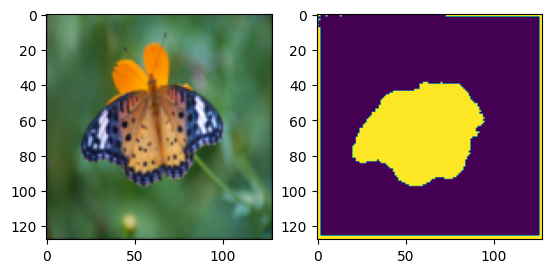

In [46]:
plt.figure()

f, axarr = plt.subplots(1,2)

axarr[0].imshow(img / 255)
axarr[1].imshow(np.squeeze(mask) > 0.5)

In [ ]:
image_id = '0030017'
(img, mask) = load_image_and_mask(images_path + image_id + '.png', mask_path + image_id + '_seg0.png')
mask2 = model(np.expand_dims(img, axis=0), training=False)

plt.figure()

f, axarr = plt.subplots(1,3)

axarr[0].imshow(img / 255)
axarr[1].imshow(np.squeeze(mask))
axarr[2].imshow(np.squeeze(mask2))